In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DateType, FloatType, DecimalType, ArrayType,MapType, DoubleType

sc = spark.sparkContext

spark = SparkSession \
    .builder \
    .appName("covid19 clustering app") \
    .getOrCreate()
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
sqlContext.setConf("spark.sql.caseSensitive", "false")

sqlContext.setConf("spark.sql.execution.arrow.enabled", "false")

# 1. Read The Dataset

In [0]:
def generate_cord19_schema():

    author_fields = [
        StructField("first", StringType()),
        StructField("middle", ArrayType(StringType())),
        StructField("last", StringType()),
        StructField("suffix", StringType()),
    ]

    authors_schema = ArrayType(
        StructType(
            author_fields
            + [
                # Uncomment to cast field into a JSON string. This field is not
                # well-specified in the source.
                StructField(
                    "affiliation",
                    StructType(
                        [
                            StructField("laboratory", StringType()),
                            StructField("institution", StringType()),
                            StructField(
                                "location",
                                StructType(
                                    [
                                        StructField("settlement", StringType()),
                                        StructField("country", StringType()),
                                    ]
                                ),
                            ),
                        ]
                    ),
                ),
                StructField("email", StringType()),
            ]
        )
    )

    # used in `section_schema` for citations, references, and equations
    spans_schema = ArrayType(
        StructType(
            [
                # character indices of inline citations
                StructField("start", IntegerType()),
                StructField("end", IntegerType()),
                StructField("text", StringType()),
                StructField("ref_id", StringType()),
            ]
        )
    )

    # A section of the paper, which includes the abstract, body, and back matter.
    section_schema = ArrayType(
        StructType(
            [
                StructField("text", StringType()),
                StructField("cite_spans", spans_schema),
                StructField("ref_spans", spans_schema),
                # While equations don't appear in the abstract, but appear here
                # for consistency
                StructField("eq_spans", spans_schema),
                StructField("section", StringType()),
            ]
        )
    )

    bib_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("ref_id", StringType()),
                StructField("title", StringType()),
                StructField("authors", ArrayType(StructType(author_fields))),
                StructField("year", IntegerType()),
                StructField("venue", StringType()),
                StructField("volume", StringType()),
                StructField("issn", StringType()),
                StructField("pages", StringType()),
                StructField(
                    "other_ids",
                    StructType([StructField("DOI", ArrayType(StringType()))]),
                ),
            ]
        ),
        True,
    )

    # Can be one of table or figure captions
    ref_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("text", StringType()),
                # Likely equation spans, not included in source schema, but
                # appears in JSON
                StructField("latex", StringType()),
                StructField("type", StringType()),
            ]
        ),
    )

    return StructType(
        [
            StructField("paper_id", StringType()),
            StructField(
                "metadata",
                StructType(
                    [
                        StructField("title", StringType()),
                        StructField("authors", authors_schema),
                    ]
                ),
                True,
            ),
            StructField("abstract", section_schema),
            StructField("body_text", section_schema),
            StructField("bib_entries", bib_schema),
            StructField("ref_entries", ref_schema),
            StructField("back_matter", section_schema),
        ]
    )


def extract_dataframe_kaggle(spark):
    
    base = "/databricks-datasets/COVID/CORD-19"
    crawled_date = "2020-03-13"
    sources = [
        "noncomm_use_subset",
        "comm_use_subset",
        "biorxiv_medrxiv",
    ]

    dataframe = None
    for source in sources:
        path = f"{base}/{crawled_date}/{source}/{source}"
        df = (
            spark.read.json(path, schema=generate_cord19_schema(), multiLine=True)
            #.withColumn("crawled_date", lit(crawled_date))
            .withColumn("source", lit(source))
        )
        if not dataframe:
            dataframe = df
        else:
            dataframe = dataframe.union(df)
    return dataframe


In [0]:
df = extract_dataframe_kaggle(spark)
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first: string (nullable = true)
 |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- last: string (nullable = true)
 |    |    |    |-- suffix: string (nullable = true)
 |    |    |    |-- affiliation: struct (nullable = true)
 |    |    |    |    |-- laboratory: string (nullable = true)
 |    |    |    |    |-- institution: string (nullable = true)
 |    |    |    |    |-- location: struct (nullable = true)
 |    |    |    |    |    |-- settlement: string (nullable = true)
 |    |    |    |    |    |-- country: string (nullable = true)
 |    |    |    |-- email: string (nullable = true)
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull =

# 2. Exploratory Data Analysis

In [0]:
#Convert DF into temp view table so we can run SQL queries on it

df.createOrReplaceTempView("covid19Table")

In [0]:
#The number of papers for each source

query = """
SELECT
    source,
    COUNT(DISTINCT paper_id)
FROM
    covid19Table
GROUP BY
    source
"""

spark.sql(query).show()

+------------------+------------------------+
|            source|count(DISTINCT paper_id)|
+------------------+------------------------+
|   biorxiv_medrxiv|                     803|
|   comm_use_subset|                    8997|
|noncomm_use_subset|                    1972|
+------------------+------------------------+



In [0]:
#The number of papers for each Author
from pyspark.sql import functions as F
authors = df.select("paper_id", F.explode("metadata.authors").alias("author")).select("paper_id", "author.*")
authors.select("first", "middle", "last", "email").where("email <> ''").show(n=5)

+--------+------+-------+--------------------+
|   first|middle|   last|               email|
+--------+------+-------+--------------------+
|  Thomas|    []|  Nolte|thomas.nolte@boeh...|
|     Uwe|   [B]| Sleytr|uwe.sleytr@boku.a...|
|  Youjun|    []|   Feng|   fengyj@zju.edu.cn|
|Changjun|    []|   Wang|changjunwang@hotm...|
| Michael|   [R]|Hamblin|hamblin@helix.mgh...|
+--------+------+-------+--------------------+
only showing top 5 rows



In [0]:
(
    authors.groupBy("first", "middle", "last")
    .agg(F.countDistinct("paper_id").alias("n_papers"))
    .orderBy(F.desc("n_papers"))
).show(n=5)

+---------+------+-------+--------+
|    first|middle|   last|n_papers|
+---------+------+-------+--------+
|        †|    []|       |     352|
|        Y|    []|       |      62|
|    Ralph|   [S]|  Baric|      54|
|Kwok-Yung|    []|   Yuen|      46|
|Christian|    []|Drosten|      46|
+---------+------+-------+--------+
only showing top 5 rows



# 3. Preparation and Cleaning the data

In [0]:
required=[
    ["metadata.title", "metadata.authors.first", "metadata.authors.last", "metadata.authors.affiliation.laboratory", "metadata.authors.affiliation.institution", "metadata.authors.affiliation.location.country", "abstract.text","body_text.text"],
    ["title", "authors_first", "authors_last", "laboratory", "institution", "country", "abstract_text","body_text_text"]
]

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, StringType

# extract = df.select([coloum for coloum in required[0] as alias for alias in required[1]])
extract_df = df.select(df["paper_id"].alias("id"),
                       df["metadata.title"].alias("titleJSON"),
                       concat_ws(' ', 
                               df["metadata.authors.first"].cast(StringType()),
                               df["metadata.authors.last"].cast(StringType())
                                ).alias("author"),
                       df["metadata.authors.affiliation.laboratory"].cast(StringType()).alias("laboratory"),
                       df["metadata.authors.affiliation.institution"].cast(StringType()).alias("institution"),
                       df["metadata.authors.affiliation.location.country"].cast(StringType()).alias("country"),
                       df["abstract.text"].cast(StringType()).alias("abstract_text"),
                       df["body_text.text"].cast(StringType()).alias("body_text")
                      )
# extract = extract.withColumn('text', extract['text'].cast(StringType()))
extract_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- titleJSON: string (nullable = true)
 |-- author: string (nullable = false)
 |-- laboratory: string (nullable = true)
 |-- institution: string (nullable = true)
 |-- country: string (nullable = true)
 |-- abstract_text: string (nullable = true)
 |-- body_text: string (nullable = true)



### Join with Metadata csv file

In [0]:
metadata_csv = spark.read\
             .format('csv')\
             .options(inferSchema=True)\
             .options(header=True)\
             .load('/FileStore/tables/metadata.csv')

In [0]:
joined_DF = metadata_csv.join(extract_df, metadata_csv.sha==extract_df.id,"inner")

In [0]:
joined_DF.toPandas().transpose()

In [0]:
extract_df.count()

Out[14]: 11772

In [0]:
metadata_csv.count()

Out[15]: 100000

In [0]:
joined_DF.count()

Out[16]: 2611

In [0]:
cols_to_drop = ("titleJSON","id","author","laboratory","institution","country","abstract_text")
joined_DF = joined_DF.drop(*cols_to_drop)

In [0]:
joined_DF.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)
 |-- body_text: string (nullable = true)



### Handling Nulls

In [0]:
#joined_DF = extract_df

In [0]:
joined_DF.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cord_uid          2611 non-null   object
 1   sha               2611 non-null   object
 2   source_x          2611 non-null   object
 3   title             2611 non-null   object
 4   doi               2611 non-null   object
 5   pmcid             2611 non-null   object
 6   pubmed_id         2572 non-null   object
 7   license           2611 non-null   object
 8   abstract          2544 non-null   object
 9   publish_time      2609 non-null   object
 10  authors           2590 non-null   object
 11  journal           2590 non-null   object
 12  mag_id            7 non-null      object
 13  who_covidence_id  7 non-null      object
 14  arxiv_id          7 non-null      object
 15  pdf_json_files    2606 non-null   object
 16  pmc_json_files    2578 non-null   object
 17  url           

In [0]:
cols_to_drop = ("mag_id","who_covidence_id","arxiv_id","s2_id")
joined_DF = joined_DF.drop(*cols_to_drop)

In [0]:
joined_DF.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cord_uid        2611 non-null   object
 1   sha             2611 non-null   object
 2   source_x        2611 non-null   object
 3   title           2611 non-null   object
 4   doi             2611 non-null   object
 5   pmcid           2611 non-null   object
 6   pubmed_id       2572 non-null   object
 7   license         2611 non-null   object
 8   abstract        2544 non-null   object
 9   publish_time    2609 non-null   object
 10  authors         2590 non-null   object
 11  journal         2590 non-null   object
 12  pdf_json_files  2606 non-null   object
 13  pmc_json_files  2578 non-null   object
 14  url             2606 non-null   object
 15  body_text       2611 non-null   object
dtypes: object(16)
memory usage: 326.5+ KB


In [0]:
joined_DF.toPandas().isnull().sum(axis=0)

Out[23]: cord_uid           0
sha                0
source_x           0
title              0
doi                0
pmcid              0
pubmed_id         39
license            0
abstract          67
publish_time       2
authors           21
journal           21
pdf_json_files     5
pmc_json_files    33
url                5
body_text          0
dtype: int64

In [0]:
joined_DF = joined_DF.na.drop()

In [0]:
joined_DF.toPandas().isnull().sum(axis=0)

Out[25]: cord_uid          0
sha               0
source_x          0
title             0
doi               0
pmcid             0
pubmed_id         0
license           0
abstract          0
publish_time      0
authors           0
journal           0
pdf_json_files    0
pmc_json_files    0
url               0
body_text         0
dtype: int64

In [0]:
(joined_DF.toPandas() == '').sum(axis=0)

Out[26]: cord_uid          0
sha               0
source_x          0
title             0
doi               0
pmcid             0
pubmed_id         0
license           0
abstract          0
publish_time      0
authors           0
journal           0
pdf_json_files    0
pmc_json_files    0
url               0
body_text         0
dtype: int64

In [0]:
joined_DF.count()

Out[27]: 2500

In [0]:
joined_DF = joined_DF.withColumnRenamed("sha","paper_id")

In [0]:
joined_DF.toPandas().transpose()

### Handling Duplications

In [0]:
joined_DF = joined_DF.dropDuplicates()

In [0]:
joined_DF.count()

Out[31]: 2500

### Filtering only english documents

In [0]:
# https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430
#detect language form text
# pandas_DF = joined_DF.toPandas()

In [0]:
%sh
pip install langdetect

  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=8d22b20f2f5282e160c6f18c78f975a73e0b40d921b03bbc058f6925f7f9fe91
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
%sh
/databricks/python3/bin/pip install spacy 
/databricks/python3/bin/python3 -m spacy download en_core_web_sm
/databricks/python3/bin/python3 -m spacy download en_core_web_md

In [0]:
#joined_DF.toPandas().transpose()

In [0]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
#from bs4 import BeautifulSoup
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_md')

In [0]:
@udf
def detect_udf(text):
    try:
        language = detect(text)
    except:
        language = "error"
    return language

In [0]:
joined_DF_lang = joined_DF.withColumn("language", detect_udf("body_text"))

In [0]:
joined_DF1 = joined_DF_lang.filter(joined_DF_lang.language == 'en')
joined_DF1 = joined_DF1.drop(joined_DF1.language)

In [0]:
# joined_DF_lang = joined_DF.withColumn("language", lit(1))
# joined_DF_lang = joined_DF_lang.toPandas()

In [0]:
# pandas_DF['language'] = pandas_DF['title'].apply(detect)

In [0]:
# pandas_DF.transpose()

In [0]:
joined_DF1.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
cord_uid,gg4qi4tj,zt6i3o86,hqxiyxfj,svnqfi51,rfs7m6or,ovoli9dr,cmw0lgpd,82m3w06s,skzidybm,f089bs8r,...,z69gstoh,7eflwyxk,tocqabgu,a9o2dvke,hwywzb0a,afg1nmib,6kq92nlx,964tbh7d,levsn7b8,lxdbwd5n
paper_id,00951716e01c8e0cc341770389fc38d1b5455210,010ad052b58172981e089bc73b9ad16a732960f2,018b618ea132d47ffb43b003a6c78cb9eeadc017,021af77daa9633d212e816cdbaf9f89240bfa3a0,02450c2c82a1511cb5e1639d3b8438f69bbe11f0,02753048c4dc699d155288935b9dc6517a79f279,03d3f764353cecb297c318e55b88be1d5664bf5c,0542a6ae26f57a5ffa35dcfebdec5004ff45688c,0568c55234a6ad2585fe3ac5f3c51260194af7ec,06190bfcbc53a5d5d17e0a60a3a0f6488d8ae1db,...,dcfbf04c5bf819de0d261d15a1936288f578d416,e1ae1fce6ed744522728aef322c22b5f239b9157,e28eedb8b780c3b08fa6a3d7d4c617f9587adc9a,ecea1d9607209bfcf32da251f53136e7f5c12f3e,ee0050c6fb81a4067d134010d0c80d21edb5df0b,ee5b43d20a640664510cb7a540caaae4a8e19933,f481624491ae43193cf1229d54d99e8ddcef9479,f8f5d842db3bc80e5c22011583b8e965abfe624c,fad068abaa998641db5de8113fced6b3ef3d613f,fdf03dcd427aa029a6b213288a7e862519decafb
source_x,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,...,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC
title,"Knowledge of, attitudes toward, and preventive...",Activation of the Unfolded Protein Response Is...,Unique Epitopes Recognized by Antibodies Induc...,MLKL Mediated Necroptosis Accelerates JEV-Indu...,GRASP depletion–mediated Golgi destruction dec...,Rabies-based vaccine induces potent immune res...,Critical role of ethics in clinical management...,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,Development of a Rapid Diagnostic Test Kit to ...,Human Ebola virus infection in West Africa: a ...,...,Ambulatory and stationary healthcare use in su...,Effects of a Non-Conservative Sequence on the ...,Viral vector-based influenza vaccines,A Vaccine of L2 Epitope Repeats Fused with a M...,Port d’Entrée for Respiratory Infections – Doe...,Evidence for the Convergence Model: The Emerge...,Respiratory Barrier as a Safeguard and Regulat...,Chinese Public Attention to the Outbreak of Eb...,Inhibition of Porphyromonas gulae and periodon...,Glycyrrhizic Acid in the Treatment of Liver Di...
doi,10.1186/1471-2458-13-242,10.1371/journal.ppat.1000176,10.1371/journal.pone.0095647,10.3389/fmicb.2017.00303,10.1091/mbc.e18-07-0462,10.1038/s41541-019-0109-5,10.2147/rmhp.s83907,10.1371/journal.pone.0101785,10.3347/kjp.2018.56.1.61,10.1186/2049-9957-3-43,...,10.1186/s13613-019-0544-5,10.1371/journal.pone.0030998,10.1080/21645515.2016.1210729,10.1371/journal.pone.0095448,10.3389/fmicb.2017.02602,10.1371/journal.pone.0138138,10.3389/fimmu.2020.00003,10.3390/ijerph13080780,10.1038/s41598-020-59730-9,10.1155/2014/872139
pmcid,PMC3608226,PMC2553261,PMC3995782,PMC5328978,PMC6589770,PMC6465360,PMC4869630,PMC4086938,PMC5858665,PMC4334593,...,PMC6570725,PMC3274521,PMC5137548,PMC4011685,PMC5742597,PMC4580613,PMC7011736,PMC4997466,PMC7033253,PMC4052927
pubmed_id,23509860,18846208,24755730,28293227,30649990,31016033,27274326,25004134,29529852,25699183,...,31201576,22347419,27455345,24802101,29312268,26398118,32117216,27527196,32080231,24963489
license,cc-by,cc-by,cc-by,cc-by,cc-by-nc-sa,cc-by,cc-by-nc,cc0,cc-by-nc,cc-by,...,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by
abstract,BACKGROUND: In endemic countries such as Bangl...,Pore-forming toxins (PFTs) constitute the sing...,Chikungunya virus (CHIKV) is an Alphavirus tha...,Japanese encephalitis virus (JEV) is the most ...,The Golgi apparatus is a membrane-bound organe...,Nipah Virus (NiV) is a re-emerging zoonotic pa...,The devastation caused by the Ebola virus dise...,BACKGROUND: Data from prospectively planned co...,We developed a Rapid Diagnostic Test (RDT) kit...,The recent outbreak of the human Zaire ebolavi...,...,BACKGROUND: For many survivors of acute respir...,We cloned the β-glucuronidase gene (AtGUS) fro...,Antigenic drift of seasonal influenza viruses ...,Current human papillomavirus (HPV) major capsi...,B

In [0]:
joined_DF1.count()

Out[44]: 2500

# 4. Preprocessing

### Remove custom stop words

In [0]:
joined_DF1 = joined_DF1.withColumnRenamed("titleJSON", "title")

In [0]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(outputCol="titleTokenized")
tokenizer.setInputCol("title")
df3 = tokenizer.transform(joined_DF1)

In [0]:
tokenizer = Tokenizer(outputCol="abstractTokenized")
tokenizer.setInputCol("abstract")
df4 = tokenizer.transform(df3)

In [0]:
tokenizer = Tokenizer(outputCol="bodytextTokenized")
tokenizer.setInputCol("body_text")
df5 = tokenizer.transform(df4)

In [0]:
from pyspark.ml.feature import StopWordsRemover
custom_stop_words = [ "doi", "preprint", "copyright", "peer", "reviewed", "org","https", "et", "al", "author", "figure","rights", "reserved", "permission", "used", "using","biorxiv", "medrxiv", "license", "fig", "fig.","al.", "Elsevier", "PMC", "CZI", "www"]
remover2 = StopWordsRemover(stopWords= custom_stop_words)
remover2.setInputCols(["titleTokenized","abstractTokenized","bodytextTokenized"]).setOutputCols(["titleCorrected","abstractCorrected","bodytextCorrected"])
df_corrected = remover2.transform(df5)

In [0]:
df_corrected.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
cord_uid,gg4qi4tj,zt6i3o86,hqxiyxfj,svnqfi51,rfs7m6or,ovoli9dr,cmw0lgpd,82m3w06s,skzidybm,f089bs8r,...,z69gstoh,7eflwyxk,tocqabgu,a9o2dvke,hwywzb0a,afg1nmib,6kq92nlx,964tbh7d,levsn7b8,lxdbwd5n
paper_id,00951716e01c8e0cc341770389fc38d1b5455210,010ad052b58172981e089bc73b9ad16a732960f2,018b618ea132d47ffb43b003a6c78cb9eeadc017,021af77daa9633d212e816cdbaf9f89240bfa3a0,02450c2c82a1511cb5e1639d3b8438f69bbe11f0,02753048c4dc699d155288935b9dc6517a79f279,03d3f764353cecb297c318e55b88be1d5664bf5c,0542a6ae26f57a5ffa35dcfebdec5004ff45688c,0568c55234a6ad2585fe3ac5f3c51260194af7ec,06190bfcbc53a5d5d17e0a60a3a0f6488d8ae1db,...,dcfbf04c5bf819de0d261d15a1936288f578d416,e1ae1fce6ed744522728aef322c22b5f239b9157,e28eedb8b780c3b08fa6a3d7d4c617f9587adc9a,ecea1d9607209bfcf32da251f53136e7f5c12f3e,ee0050c6fb81a4067d134010d0c80d21edb5df0b,ee5b43d20a640664510cb7a540caaae4a8e19933,f481624491ae43193cf1229d54d99e8ddcef9479,f8f5d842db3bc80e5c22011583b8e965abfe624c,fad068abaa998641db5de8113fced6b3ef3d613f,fdf03dcd427aa029a6b213288a7e862519decafb
source_x,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,...,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC,PMC
title,"Knowledge of, attitudes toward, and preventive...",Activation of the Unfolded Protein Response Is...,Unique Epitopes Recognized by Antibodies Induc...,MLKL Mediated Necroptosis Accelerates JEV-Indu...,GRASP depletion–mediated Golgi destruction dec...,Rabies-based vaccine induces potent immune res...,Critical role of ethics in clinical management...,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,Development of a Rapid Diagnostic Test Kit to ...,Human Ebola virus infection in West Africa: a ...,...,Ambulatory and stationary healthcare use in su...,Effects of a Non-Conservative Sequence on the ...,Viral vector-based influenza vaccines,A Vaccine of L2 Epitope Repeats Fused with a M...,Port d’Entrée for Respiratory Infections – Doe...,Evidence for the Convergence Model: The Emerge...,Respiratory Barrier as a Safeguard and Regulat...,Chinese Public Attention to the Outbreak of Eb...,Inhibition of Porphyromonas gulae and periodon...,Glycyrrhizic Acid in the Treatment of Liver Di...
doi,10.1186/1471-2458-13-242,10.1371/journal.ppat.1000176,10.1371/journal.pone.0095647,10.3389/fmicb.2017.00303,10.1091/mbc.e18-07-0462,10.1038/s41541-019-0109-5,10.2147/rmhp.s83907,10.1371/journal.pone.0101785,10.3347/kjp.2018.56.1.61,10.1186/2049-9957-3-43,...,10.1186/s13613-019-0544-5,10.1371/journal.pone.0030998,10.1080/21645515.2016.1210729,10.1371/journal.pone.0095448,10.3389/fmicb.2017.02602,10.1371/journal.pone.0138138,10.3389/fimmu.2020.00003,10.3390/ijerph13080780,10.1038/s41598-020-59730-9,10.1155/2014/872139
pmcid,PMC3608226,PMC2553261,PMC3995782,PMC5328978,PMC6589770,PMC6465360,PMC4869630,PMC4086938,PMC5858665,PMC4334593,...,PMC6570725,PMC3274521,PMC5137548,PMC4011685,PMC5742597,PMC4580613,PMC7011736,PMC4997466,PMC7033253,PMC4052927
pubmed_id,23509860,18846208,24755730,28293227,30649990,31016033,27274326,25004134,29529852,25699183,...,31201576,22347419,27455345,24802101,29312268,26398118,32117216,27527196,32080231,24963489
license,cc-by,cc-by,cc-by,cc-by,cc-by-nc-sa,cc-by,cc-by-nc,cc0,cc-by-nc,cc-by,...,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by,cc-by
abstract,BACKGROUND: In endemic countries such as Bangl...,Pore-forming toxins (PFTs) constitute the sing...,Chikungunya virus (CHIKV) is an Alphavirus tha...,Japanese encephalitis virus (JEV) is the most ...,The Golgi apparatus is a membrane-bound organe...,Nipah Virus (NiV) is a re-emerging zoonotic pa...,The devastation caused by the Ebola virus dise...,BACKGROUND: Data from prospectively planned co...,We developed a Rapid Diagnostic Test (RDT) kit...,The recent outbreak of the human Zaire ebolavi...,...,BACKGROUND: For many survivors of acute respir...,We cloned the β-glucuronidase gene (AtGUS) fro...,Antigenic drift of seasonal influenza viruses ...,Current human papillomavirus (HPV) major capsi...,B

In [0]:
no_stp_words_df = df_corrected.select(df_corrected["paper_id"].alias("id"),
                       df_corrected["title"].cast(StringType()).alias("original_title"),               
                       df_corrected["titleCorrected"].cast(StringType()).alias("title"),
                       df_corrected["abstractCorrected"].cast(StringType()).alias("abstract"),
                       df_corrected["bodytextCorrected"].cast(StringType()).alias("bodytext"),
                       df_corrected["authors"].cast(StringType()).alias("author")
                      )

### Remover Puncutation

In [0]:
import re
commaRep = udf(lambda x: re.sub('[\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\–]','', x))
no_stp_words_df=no_stp_words_df.withColumn('title_no_punc',commaRep('title')).withColumn('abstract_no_punc',commaRep('abstract')).withColumn('bodytext_no_punc',commaRep('bodytext')).withColumn('author_no_punc',commaRep('author'))

In [0]:
no_stp_words_df.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
id,00951716e01c8e0cc341770389fc38d1b5455210,010ad052b58172981e089bc73b9ad16a732960f2,018b618ea132d47ffb43b003a6c78cb9eeadc017,021af77daa9633d212e816cdbaf9f89240bfa3a0,02450c2c82a1511cb5e1639d3b8438f69bbe11f0,02753048c4dc699d155288935b9dc6517a79f279,03d3f764353cecb297c318e55b88be1d5664bf5c,0542a6ae26f57a5ffa35dcfebdec5004ff45688c,0568c55234a6ad2585fe3ac5f3c51260194af7ec,06190bfcbc53a5d5d17e0a60a3a0f6488d8ae1db,...,dcfbf04c5bf819de0d261d15a1936288f578d416,e1ae1fce6ed744522728aef322c22b5f239b9157,e28eedb8b780c3b08fa6a3d7d4c617f9587adc9a,ecea1d9607209bfcf32da251f53136e7f5c12f3e,ee0050c6fb81a4067d134010d0c80d21edb5df0b,ee5b43d20a640664510cb7a540caaae4a8e19933,f481624491ae43193cf1229d54d99e8ddcef9479,f8f5d842db3bc80e5c22011583b8e965abfe624c,fad068abaa998641db5de8113fced6b3ef3d613f,fdf03dcd427aa029a6b213288a7e862519decafb
original_title,"Knowledge of, attitudes toward, and preventive...",Activation of the Unfolded Protein Response Is...,Unique Epitopes Recognized by Antibodies Induc...,MLKL Mediated Necroptosis Accelerates JEV-Indu...,GRASP depletion–mediated Golgi destruction dec...,Rabies-based vaccine induces potent immune res...,Critical role of ethics in clinical management...,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,Development of a Rapid Diagnostic Test Kit to ...,Human Ebola virus infection in West Africa: a ...,...,Ambulatory and stationary healthcare use in su...,Effects of a Non-Conservative Sequence on the ...,Viral vector-based influenza vaccines,A Vaccine of L2 Epitope Repeats Fused with a M...,Port d’Entrée for Respiratory Infections – Doe...,Evidence for the Convergence Model: The Emerge...,Respiratory Barrier as a Safeguard and Regulat...,Chinese Public Attention to the Outbreak of Eb...,Inhibition of Porphyromonas gulae and periodon...,Glycyrrhizic Acid in the Treatment of Liver Di...
title,"[knowledge, of,, attitudes, toward,, and, prev...","[activation, of, the, unfolded, protein, respo...","[unique, epitopes, recognized, by, antibodies,...","[mlkl, mediated, necroptosis, accelerates, jev...","[grasp, depletion–mediated, golgi, destruction...","[rabies-based, vaccine, induces, potent, immun...","[critical, role, of, ethics, in, clinical, man...","[outcomes, of, influenza, a(h1n1)pdm09, virus,...","[development, of, a, rapid, diagnostic, test, ...","[human, ebola, virus, infection, in, west, afr...",...,"[ambulatory, and, stationary, healthcare, use,...","[effects, of, a, non-conservative, sequence, o...","[viral, vector-based, influenza, vaccines]","[a, vaccine, of, l2, epitope, repeats, fused, ...","[port, d’entrée, for, respiratory, infections,...","[evidence, for, the, convergence, model:, the,...","[respiratory, barrier, as, a, safeguard, and, ...","[chinese, public, attention, to, the, outbreak...","[inhibition, of, porphyromonas, gulae, and, pe...","[glycyrrhizic, acid, in, the, treatment, of, l..."
abstract,"[background:, in, endemic, countries, such, as...","[pore-forming, toxins, (pfts), constitute, the...","[chikungunya, virus, (chikv), is, an, alphavir...","[japanese, encephalitis, virus, (jev), is, the...","[the, golgi, apparatus, is, a, membrane-bound,...","[nipah, virus, (niv), is, a, re-emerging, zoon...","[the, devastation, caused, by, the, ebola, vir...","[background:, data, from, prospectively, plann...","[we, developed, a, rapid, diagnostic, test, (r...","[the, recent, outbreak, of, the, human, zaire,...",...,"[background:, for, many, survivors, of, acute,...","[we, cloned, the, β-glucuronidase, gene, (atgu...","[antigenic, drift, of, seasonal, influenza, vi...","[current, human, papillomavirus, (hpv), major,...","[bacterial, and, viral, co-infections, of, the...","[building, on, a, series, of, ground, breaking...","[the, primary, function, of, the, respiratory,...","[objective:, the, outbreak, of, the, ebola, ep...","[porphyromonas, gulae, is, a, major, periodont...","[glycyrrhizic, acid, (ga), is, a, triterpene

In [0]:
DF_corrected = no_stp_words_df.select(no_stp_words_df["id"].alias("id"),
                       no_stp_words_df["original_title"].cast(StringType()).alias("original_title"),               
                       no_stp_words_df["title_no_punc"].cast(StringType()).alias("title"),
                       no_stp_words_df["abstract_no_punc"].cast(StringType()).alias("abstract"),
                       no_stp_words_df["bodytext_no_punc"].cast(StringType()).alias("bodytext"),
                       no_stp_words_df["author_no_punc"].cast(StringType()).alias("author")
                      )

In [0]:
DF_corrected.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
id,00951716e01c8e0cc341770389fc38d1b5455210,010ad052b58172981e089bc73b9ad16a732960f2,018b618ea132d47ffb43b003a6c78cb9eeadc017,021af77daa9633d212e816cdbaf9f89240bfa3a0,02450c2c82a1511cb5e1639d3b8438f69bbe11f0,02753048c4dc699d155288935b9dc6517a79f279,03d3f764353cecb297c318e55b88be1d5664bf5c,0542a6ae26f57a5ffa35dcfebdec5004ff45688c,0568c55234a6ad2585fe3ac5f3c51260194af7ec,06190bfcbc53a5d5d17e0a60a3a0f6488d8ae1db,...,dcfbf04c5bf819de0d261d15a1936288f578d416,e1ae1fce6ed744522728aef322c22b5f239b9157,e28eedb8b780c3b08fa6a3d7d4c617f9587adc9a,ecea1d9607209bfcf32da251f53136e7f5c12f3e,ee0050c6fb81a4067d134010d0c80d21edb5df0b,ee5b43d20a640664510cb7a540caaae4a8e19933,f481624491ae43193cf1229d54d99e8ddcef9479,f8f5d842db3bc80e5c22011583b8e965abfe624c,fad068abaa998641db5de8113fced6b3ef3d613f,fdf03dcd427aa029a6b213288a7e862519decafb
original_title,"Knowledge of, attitudes toward, and preventive...",Activation of the Unfolded Protein Response Is...,Unique Epitopes Recognized by Antibodies Induc...,MLKL Mediated Necroptosis Accelerates JEV-Indu...,GRASP depletion–mediated Golgi destruction dec...,Rabies-based vaccine induces potent immune res...,Critical role of ethics in clinical management...,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,Development of a Rapid Diagnostic Test Kit to ...,Human Ebola virus infection in West Africa: a ...,...,Ambulatory and stationary healthcare use in su...,Effects of a Non-Conservative Sequence on the ...,Viral vector-based influenza vaccines,A Vaccine of L2 Epitope Repeats Fused with a M...,Port d’Entrée for Respiratory Infections – Doe...,Evidence for the Convergence Model: The Emerge...,Respiratory Barrier as a Safeguard and Regulat...,Chinese Public Attention to the Outbreak of Eb...,Inhibition of Porphyromonas gulae and periodon...,Glycyrrhizic Acid in the Treatment of Liver Di...
title,knowledge of attitudes toward and preventive p...,activation of the unfolded protein response is...,unique epitopes recognized by antibodies induc...,mlkl mediated necroptosis accelerates jevinduc...,grasp depletionmediated golgi destruction decr...,rabiesbased vaccine induces potent immune resp...,critical role of ethics in clinical management...,outcomes of influenza ah1n1pdm09 virus infecti...,development of a rapid diagnostic test kit to ...,human ebola virus infection in west africa a r...,...,ambulatory and stationary healthcare use in su...,effects of a nonconservative sequence on the p...,viral vectorbased influenza vaccines,a vaccine of l2 epitope repeats fused with a m...,port d’entrée for respiratory infections does...,evidence for the convergence model the emergen...,respiratory barrier as a safeguard and regulat...,chinese public attention to the outbreak of eb...,inhibition of porphyromonas gulae and periodon...,glycyrrhizic acid in the treatment of liver di...
abstract,background in endemic countries such as bangla...,poreforming toxins pfts constitute the single ...,chikungunya virus chikv is an alphavirus that ...,japanese encephalitis virus jev is the most pr...,the golgi apparatus is a membranebound organel...,nipah virus niv is a reemerging zoonotic patho...,the devastation caused by the ebola virus dise...,background data from prospectively planned coh...,we developed a rapid diagnostic test rdt kit f...,the recent outbreak of the human zaire ebolavi...,...,background for many survivors of acute respira...,we cloned the βglucuronidase gene atgus from a...,antigenic drift of seasonal influenza viruses ...,current human papillomavirus hpv major capsid ...,bacterial and viral coinfections of the respir...,building on a series of ground breaking review...,the primary function of the respiratory system...,objective the outbreak of the ebola epidemic i...,porphyromonas gulae is a major periodontal pat...,glycyrrhizic acid ga is a triterpene glycoside...
bodytext,cholera is a waterborne lifethreatening form o...,poreforming toxins pf

### convert text to lower case

In [0]:
from pyspark.sql.functions import lower, col
# extracted_df.withColumn('bar', lower(col('bar')))
# We already has the other columns in lower case we will only convert the author column.
DF_Final = DF_corrected.withColumn('authors', lower(col('author')))
DF_Final = DF_Final.drop('author')

In [0]:
DF_Final.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
id,00951716e01c8e0cc341770389fc38d1b5455210,010ad052b58172981e089bc73b9ad16a732960f2,018b618ea132d47ffb43b003a6c78cb9eeadc017,021af77daa9633d212e816cdbaf9f89240bfa3a0,02450c2c82a1511cb5e1639d3b8438f69bbe11f0,02753048c4dc699d155288935b9dc6517a79f279,03d3f764353cecb297c318e55b88be1d5664bf5c,0542a6ae26f57a5ffa35dcfebdec5004ff45688c,0568c55234a6ad2585fe3ac5f3c51260194af7ec,06190bfcbc53a5d5d17e0a60a3a0f6488d8ae1db,...,dcfbf04c5bf819de0d261d15a1936288f578d416,e1ae1fce6ed744522728aef322c22b5f239b9157,e28eedb8b780c3b08fa6a3d7d4c617f9587adc9a,ecea1d9607209bfcf32da251f53136e7f5c12f3e,ee0050c6fb81a4067d134010d0c80d21edb5df0b,ee5b43d20a640664510cb7a540caaae4a8e19933,f481624491ae43193cf1229d54d99e8ddcef9479,f8f5d842db3bc80e5c22011583b8e965abfe624c,fad068abaa998641db5de8113fced6b3ef3d613f,fdf03dcd427aa029a6b213288a7e862519decafb
original_title,"Knowledge of, attitudes toward, and preventive...",Activation of the Unfolded Protein Response Is...,Unique Epitopes Recognized by Antibodies Induc...,MLKL Mediated Necroptosis Accelerates JEV-Indu...,GRASP depletion–mediated Golgi destruction dec...,Rabies-based vaccine induces potent immune res...,Critical role of ethics in clinical management...,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,Development of a Rapid Diagnostic Test Kit to ...,Human Ebola virus infection in West Africa: a ...,...,Ambulatory and stationary healthcare use in su...,Effects of a Non-Conservative Sequence on the ...,Viral vector-based influenza vaccines,A Vaccine of L2 Epitope Repeats Fused with a M...,Port d’Entrée for Respiratory Infections – Doe...,Evidence for the Convergence Model: The Emerge...,Respiratory Barrier as a Safeguard and Regulat...,Chinese Public Attention to the Outbreak of Eb...,Inhibition of Porphyromonas gulae and periodon...,Glycyrrhizic Acid in the Treatment of Liver Di...
title,knowledge of attitudes toward and preventive p...,activation of the unfolded protein response is...,unique epitopes recognized by antibodies induc...,mlkl mediated necroptosis accelerates jevinduc...,grasp depletionmediated golgi destruction decr...,rabiesbased vaccine induces potent immune resp...,critical role of ethics in clinical management...,outcomes of influenza ah1n1pdm09 virus infecti...,development of a rapid diagnostic test kit to ...,human ebola virus infection in west africa a r...,...,ambulatory and stationary healthcare use in su...,effects of a nonconservative sequence on the p...,viral vectorbased influenza vaccines,a vaccine of l2 epitope repeats fused with a m...,port d’entrée for respiratory infections does...,evidence for the convergence model the emergen...,respiratory barrier as a safeguard and regulat...,chinese public attention to the outbreak of eb...,inhibition of porphyromonas gulae and periodon...,glycyrrhizic acid in the treatment of liver di...
abstract,background in endemic countries such as bangla...,poreforming toxins pfts constitute the single ...,chikungunya virus chikv is an alphavirus that ...,japanese encephalitis virus jev is the most pr...,the golgi apparatus is a membranebound organel...,nipah virus niv is a reemerging zoonotic patho...,the devastation caused by the ebola virus dise...,background data from prospectively planned coh...,we developed a rapid diagnostic test rdt kit f...,the recent outbreak of the human zaire ebolavi...,...,background for many survivors of acute respira...,we cloned the βglucuronidase gene atgus from a...,antigenic drift of seasonal influenza viruses ...,current human papillomavirus hpv major capsid ...,bacterial and viral coinfections of the respir...,building on a series of ground breaking review...,the primary function of the respiratory system...,objective the outbreak of the ebola epidemic i...,porphyromonas gulae is a major periodontal pat...,glycyrrhizic acid ga is a triterpene glycoside...
bodytext,cholera is a waterborne lifethreatening form o...,poreforming toxins pf

# 5. Vectorization

In [0]:
DF_Final.columns

Out[193]: ['id', 'original_title', 'title', 'abstract', 'bodytext', 'authors']

In [0]:
# extract_df = extract_df.withColumn("words", concat_ws(" ", col(x for x in extract_df.columns)))

#### Prepare data to be used by K-means clusstering

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
# Prepare relevant text columns to be tokenized
DF_Final = DF_Final.drop("words")
DF_Final = DF_Final.withColumn("sentence", concat_ws(" ", \
                                                      DF_Final.id, DF_Final.title, DF_Final.abstract,\
                                                      DF_Final.bodytext, \
                                                      DF_Final.authors\
                                                     ))
tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(DF_Final)
# wordsData.toPandas()

In [0]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)
# featurizedData.toPandas()

In [0]:
# To see how rawReatures look like
featurizedData.select("rawFeatures").toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
rawFeatures,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [0]:
rescaledData.select("title", "features").toPandas()

,title,features
0,knowledge of attitudes toward and preventive p...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,activation of the unfolded protein response is...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,unique epitopes recognized by antibodies induc...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,mlkl mediated necroptosis accelerates jevinduc...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,grasp depletionmediated golgi destruction decr...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
2495,evidence for the convergence model the emergen...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2496,respiratory barrier as a safeguard and regulat...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2497,chinese public attention to the outbreak of eb...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2498,inhibition of porphyromonas gulae and periodon...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Save dataframe in table, to start from here when working on next part

In [0]:
rescaledData.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/FileStore/tables/project5/delta-table")

# 6. Clustering

In [0]:
delta_df = spark.read.format("delta").load("/FileStore/tables/project5/delta-table")

In [0]:
# Check the loaded table
delta_df.select("title", "features").toPandas()

,title,features
0,interferonγ inhibits ebola virus infection,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,classification of viral zoonosis through recep...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,subclinical in utero zika virus infection is a...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,bat astroviruses towards understanding the tra...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,sirt7dependent deacetylation of cdk9 activates...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
2495,evidence for the convergence model the emergen...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2496,respiratory barrier as a safeguard and regulat...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2497,chinese public attention to the outbreak of eb...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2498,inhibition of porphyromonas gulae and periodon...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
delta_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- bodytext: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



### Applying PCA for dimentionality reduction

In [0]:
from pyspark.ml.linalg import *
skip_pca = 1

In [0]:
@udf(ArrayType(FloatType()))
def  toDense(v):

    v = DenseVector(v)

    new_array = list([float(x) for x in v])

    return new_array 

In [0]:
toDense = udf(lambda vector: DenseVector(vector.toArray()))

In [0]:
pca_df = delta_df.select(delta_df.original_title.cast(StringType()),
                         delta_df.features)
pca_df=pca_df.withColumn('PCA_features',toDense('features'))

In [0]:
pca_df.printSchema()

root
 |-- original_title: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- PCA_features: string (nullable = true)



In [0]:
from pyspark.ml.feature import PCA as PCAml
if skip_pca == 0:
    pca = PCAml(k=20, inputCol="PCA_features", outputCol="pca_output_features")
    pca_model = pca.fit(pca_df)
    pca_transformed = pca_model.transform(pca_df)

### Calculate cost and plot

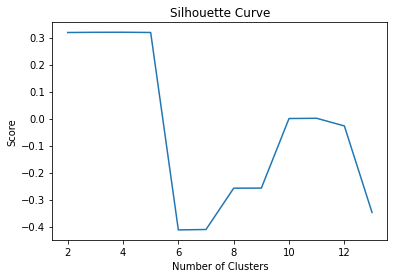

In [0]:
import numpy as np
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

cost = np.zeros(14)

for k in range(2,14):
    kmeans = KMeans().setK(k).setSeed(7).setFeaturesCol('features')
    model = kmeans.fit(delta_df)
    clusterdData = model.transform(delta_df)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(clusterdData)
    
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Silhouette Curve')
pl.show()

## From the curve we choose k = 5

In [0]:
k=5

In [0]:
kmeans = KMeans().setK(k).setSeed(7).setFeaturesCol('features')
model = kmeans.fit(delta_df)
clusterdData = model.transform(delta_df)

# 7. Recommender system

In [0]:
# Global Variable to hold the features vector of the passed papper
feat = 0

In [0]:
@udf
def sim_cos(v1):
    global feat
    v2 = feat
    try:
        p = 2
        return float(v1.dot(v2))/float(v1.norm(p)*v2.norm(p))
    except:
        return 0

### Create dataframes for each cluster and save it to make processing faster

In [0]:
clusterdData.count()

Out[215]: 2500

In [0]:
clusters=[]
for i in range(k):
    sub_df = clusterdData.filter(clusterdData.prediction == i)
    print(sub_df.count())
    clusters.append(sub_df)

2478
19
1
1
1


In [0]:
def recommendPaper(paper_title,N=1):
    global feat
    recommendedList = []
    try:
    # get predited cluster
        d = clusterdData.filter(clusterdData.title.contains(paper_title))
#         print("d")
        p = d.head()["prediction"]
        feat = d.head()["features"]
        sel_cluster = clusters[p]
        df_with_CosSim = sel_cluster.withColumn("CosSim",  sim_cos("features").cast(FloatType()))
        df_with_CosSim = df_with_CosSim.orderBy(df_with_CosSim.CosSim.desc())
        max_number = df_with_CosSim.count()
        N = max_number if N>max_number else N    
        recommendedList = df_with_CosSim.limit(N+1)
    except:
        print("paper is not in our database")
    return recommendedList

In [0]:
x = recommendPaper("chinese public attention to the outbreak", 5)

In [0]:
x.toPandas()

,id,original_title,title,abstract,bodytext,authors,sentence,words,rawFeatures,features,prediction,CosSim
0,f8f5d842db3bc80e5c22011583b8e965abfe624c,Chinese Public Attention to the Outbreak of Eb...,chinese public attention to the outbreak of eb...,objective the outbreak of the ebola epidemic i...,the ebola epidemic of west africa had been vie...,liu kui li li jiang tao chen bin jiang zhengga...,f8f5d842db3bc80e5c22011583b8e965abfe624c chine...,"[f8f5d842db3bc80e5c22011583b8e965abfe624c, chi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1.000000
1,b973a418c19776904cffc71357c7119485bf2b3a,The Large Scale Machine Learning in an Artific...,the large scale machine learning in an artific...,ebola virus disease evd distinguishes its feat...,ebola epidemic in west africa has aroused high...,zhang peng chen bin ma liang li zhen song zhic...,b973a418c19776904cffc71357c7119485bf2b3a the l...,"[b973a418c19776904cffc71357c7119485bf2b3a, the...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.091804
2,20b5fc51aef8b077346c4587aad3811eebf8b11b,Monitoring Influenza Epidemics in China with S...,monitoring influenza epidemics in china with s...,several approaches have been proposed for near...,seasonal influenza epidemics result in an esti...,yuan qingyu nsoesie elaine o lv benfu peng gen...,20b5fc51aef8b077346c4587aad3811eebf8b11b monit...,"[20b5fc51aef8b077346c4587aad3811eebf8b11b, mon...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.091383
3,d06b1f07cc3e2f1ac0dbcd16995fc351a1bafe91,Characterizing the Transmission Dynamics and C...,characterizing the transmission dynamics and c...,carefully calibrated transmission models have ...,ebola virus disease evd is caused by an rna vi...,chowell gerardo nishiura hiroshi,d06b1f07cc3e2f1ac0dbcd16995fc351a1bafe91 chara...,"[d06b1f07cc3e2f1ac0dbcd16995fc351a1bafe91, cha...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.090070
4,a52fd1386e8a463e46bde0e66125bfd826a64f56,Ebola virus disease and critical illness,ebola virus disease and critical illness,as of 20 may 2016 there have been 28646 cases ...,in december 2013 transmission of zaire ebolavi...,leligdowicz aleksandra fischer william a uyeki...,a52fd1386e8a463e46bde0e66125bfd826a64f56 ebola...,"[a52fd1386e8a463e46bde0e66125bfd826a64f56, ebo...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.087196
5,17e4de7b95ed440d0df3a87e85e9fca8b64b0de7,Incorporating media data into a model of infec...,incorporating media data into a model of infec...,understanding the effect of media on disease s...,disease transmission takes place in a dynamic ...,kim louis fast shannon m markuzon natasha,17e4de7b95ed440d0df3a87e85e9fca8b64b0de7 incor...,"[17e4de7b95ed440d0df3a87e85e9fca8b64b0de7, inc...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.085854


In [0]:
y = recommendPaper("Any Paper Not in DB", 5)
# y.toPandas()

paper is not in our database
